In [2]:
# 股票数据
import os
stockName = [i.split('.')[0] for i in os.listdir(r'..\Data')][:-2]
stockName[4]

'002415_SZ'

In [7]:
# Behavior clone 训练
from Model.BC.Behavioral_Cloning_Agent import BehaviorClone

def multi_train_BC(code, times):

    bc_agent = BehaviorClone(state_dim=150, hidden_dim=50, action_dim=3, device="cuda:0", lr=0.01,
                             timeperiod=15,
                             K=2000,
                             path=r'..\Data\\'+code+'.csv',
                             batch_size=512)
    # 训练 DDQN_Behavior_clone
    bc_agent.train_BC(episode=times,
                      dqn_path=r'..\Model\BC\Q_network\\'+code+'_BC_DQN.pt',
                      ddqn_path=r'..\Model\BC\Dueling_Q_network\\'+code+'_BC_DDQN.pt',
                      type='DDQN')
    # 训练 DQN_Behavior_clone
    bc_agent.train_BC(episode=times,
                      dqn_path=r'..\Model\BC\Q_network\\'+code+'_BC_DQN.pt',
                      ddqn_path=r'..\Model\BC\Dueling_Q_network\\'+code+'_BC_DQN.pt',
                      type='DQN')
    del bc_agent


In [8]:
# 行为克隆 单只股票训练
multi_train_BC(code=stockName[4], times=2500)

Episode: 0 The Imitate Agent has learned, the Loss is: 694.20751953125
Episode: 1 The Imitate Agent has learned, the Loss is: 4850.7998046875
Episode: 2 The Imitate Agent has learned, the Loss is: 1962.03955078125
Episode: 3 The Imitate Agent has learned, the Loss is: 2811.720703125
Episode: 4 The Imitate Agent has learned, the Loss is: 1360.91650390625
Episode: 5 The Imitate Agent has learned, the Loss is: 3280.19580078125
Episode: 6 The Imitate Agent has learned, the Loss is: 1477.731201171875
Episode: 7 The Imitate Agent has learned, the Loss is: 3065.1982421875
Episode: 8 The Imitate Agent has learned, the Loss is: 1372.624755859375
Episode: 9 The Imitate Agent has learned, the Loss is: 2477.88818359375
Episode: 10 The Imitate Agent has learned, the Loss is: 626.562255859375
Episode: 11 The Imitate Agent has learned, the Loss is: 2242.9033203125
Episode: 12 The Imitate Agent has learned, the Loss is: 974.5794067382812
Episode: 13 The Imitate Agent has learned, the Loss is: 1965.029

In [3]:
# Behavior clone 批量训练
for name in stockName:
    multi_train_BC(code=name, times=2500)

Episode: 0 The Imitate Agent has learned, the Loss is: 3814.58935546875
Episode: 1 The Imitate Agent has learned, the Loss is: 21698.51953125
Episode: 2 The Imitate Agent has learned, the Loss is: 3170.981201171875
Episode: 3 The Imitate Agent has learned, the Loss is: 17380.970703125
Episode: 4 The Imitate Agent has learned, the Loss is: 2751.033203125
Episode: 5 The Imitate Agent has learned, the Loss is: 13927.03125
Episode: 6 The Imitate Agent has learned, the Loss is: 2851.183837890625
Episode: 7 The Imitate Agent has learned, the Loss is: 11222.7099609375
Episode: 8 The Imitate Agent has learned, the Loss is: 5942.2109375
Episode: 9 The Imitate Agent has learned, the Loss is: 10356.62890625
Episode: 10 The Imitate Agent has learned, the Loss is: 5038.41064453125
Episode: 11 The Imitate Agent has learned, the Loss is: 6614.767578125
Episode: 12 The Imitate Agent has learned, the Loss is: 4801.798828125
Episode: 13 The Imitate Agent has learned, the Loss is: 4378.2861328125
Episode

In [5]:
# Dueling DQN 训练
import torch
from Data.stock_data import data
from Model.DDQN.Dueling_DQN import DDQN_Agent
from Env.trainEnv import portfolio_trainEnv
# 实例化智能体
agent = DDQN_Agent(state_dim=150, hidden_dim=30, action_dim=3, lr=0.001, device="cuda:0", gamma=0.95,  epsilon=0.01, target_update=10)
# 训练
def DDQN_train(episode, minimum, stockName):
    # 训练数据
    link = r'..\Data\\'+stockName+'.csv'
    train_df = data(link, window_length=15, t=2000).train_data()
    # 训练环境
    Env = portfolio_trainEnv(day=0, balance=100000, stock=train_df, cost=0.003)
    return_List = []
    for i in range(episode):
        # print('Episode:', i)
        done = False
        episode_return  = 0
        state = Env.reset()  # 返回初始状态
        state = torch.tensor(state.values, dtype=torch.float32).view(1, -1).to(device="cuda:0")
        # 智能体经验池
        transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': [],
            }
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, _ = Env.step(action)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action+1)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            next_state = torch.tensor(next_state.values, dtype=torch.float32).view(1, -1).to(device="cuda:0")
            transition_dict['next_states'].append(next_state)
            state = next_state
            episode_return += reward
            if len(transition_dict['states'])>= minimum:
               # 智能体学习
               agent.update(transition_dict)
        return_List.append(episode_return)
    # 模型保存
    PATH = r'..\Model\DDQN\result\agent_ddqn_'+stockName+'.pt'
    torch.save(agent.state_dict(), PATH, _use_new_zipfile_serialization=False)

    import matplotlib.pyplot as plt
    # 每慕内奖励总和
    time = []
    for i in train_df:
        time.append(str(i.index.unique().values[-1]))
    Name = link.split('\\')[-1].split('.')[0]
    # 策略收益率
    plt.figure(figsize=(10, 3))
    plt.title('DDQN: The Episode Reward of '+Name)
    plt.grid()
    plt.plot(range(1, len(return_List)+1), return_List)
    plt.show()


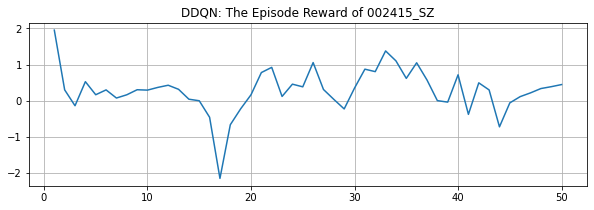

In [6]:
DDQN_train(episode=50, minimum=1500, stockName=stockName[4])

In [ ]:
for i in stockName:
    return_list =  DDQN_train(episode=100, minimum=1500, stockName=i)

In [8]:
# DQN 训练
import warnings
warnings.filterwarnings('ignore')
import torch
from Data.stock_data import data
from Model.DQN.Deep_Q_Network import DQN_Agent
from Env.trainEnv import portfolio_trainEnv
# 实例化智能体
agent = DQN_Agent(state_dim=150, hidden_dim=30, action_dim=3, lr=0.001, device="cuda:0", gamma=0.95,  epsilon=0.01, target_update=10)
# 训练
def DQN_train(episode, minimum, stockName):
    # 训练数据
    link = r'..\Data\\'+stockName+'.csv'
    train_df = data(link, window_length=15, t=2000).train_data()
    # 训练环境
    Env = portfolio_trainEnv(day=0, balance=100000, stock=train_df, cost=0.003)
    return_List = []
    for i in range(episode):
        # print('Episode:', i)
        done = False
        episode_return  = 0
        state = Env.reset()  # 返回初始状态
        state = torch.tensor(state.values, dtype=torch.float32).view(1, -1).to(device="cuda:0")
        # 智能体经验池
        transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': [],
            }
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, _ = Env.step(action)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action+1)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            next_state = torch.tensor(next_state.values, dtype=torch.float32).view(1, -1).to(device="cuda:0")
            transition_dict['next_states'].append(next_state)
            state = next_state
            episode_return += reward
            if len(transition_dict['states'])>= minimum:
               # 智能体学习
               agent.update(transition_dict)
        return_List.append(episode_return)
    # 模型保存
    PATH = r'..\Model\DQN\result\agent_dqn_'+stockName+'.pt'
    torch.save(agent.state_dict(), PATH, _use_new_zipfile_serialization=False)

    import matplotlib.pyplot as plt
    # 每慕内奖励总和
    time = []
    for i in train_df:
        time.append(str(i.index.unique().values[-1]))
    Name = link.split('\\')[-1].split('.')[0]
    # 策略收益率
    plt.figure(figsize=(10, 3))
    plt.title('DQN: The Episode Reward of '+Name)
    plt.grid()
    plt.plot(range(1, len(return_List)+1), return_List)
    plt.show()

    # return return_List


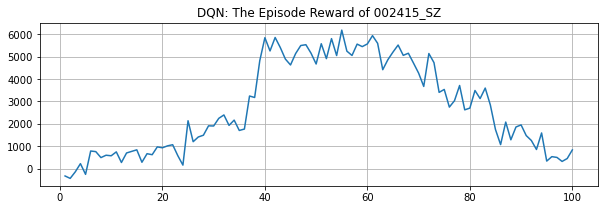

In [9]:
DQN_train(episode=100, minimum=1500, stockName=stockName[5])

In [ ]:
# DQN 训练
for i in stockName:
     return_list = DQN_train(episode=100, minimum=1500, stockName=i)

In [2]:
# Dueling DQN Imitative Learning
import torch
from Data.stock_data import data
from Model.ILQN.IL_Agent import IL_Agent
from Env.trainEnv import portfolio_trainEnv
# 专家训练
from Expert.Imitate_Expert import Expert

agent = IL_Agent(state_dim=150, hidden_dim=30, action_dim=3, lr=0.001, device="cuda:0", gamma=0.95,  epsilon=0.01, target_update=10)

def IL_DDQN_train(episode, minimum, stockName, lambda_1, lambda_2):
    link = r'..\Data\\'+stockName+'.csv'
    train_df = data(link, window_length=15, t=2000).train_data()
    # 训练环境
    Env = portfolio_trainEnv(day=0, balance=100000, stock=train_df, cost=0.003)
    # 专家
    expert = Expert(path=link, timeperiod=15)
    expert_transition_dict = expert.sample_expert_data(K=2000)
    return_List = []
    for i in range(episode):
        # print('Episode:', i)
        done = False
        episode_return  = 0
        state = Env.reset()  # 返回初始状态
        state = torch.tensor(state.values, dtype=torch.float32).view(1, -1).to(device="cuda:0")
        # 经验池
        transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': [],
            }
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, _ = Env.step(action)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action+1)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            next_state = torch.tensor(next_state.values, dtype=torch.float32).view(1, -1).to(device="cuda:0")
            transition_dict['next_states'].append(next_state)
            state = next_state
            episode_return += reward
            if len(transition_dict['states'])>= minimum:
               # 算法优化 超参数灵敏度分析
               agent.update(transition_dict, expert_transition_dict, lambda_1, lambda_2)
        return_List.append(episode_return)

    # 模型保存
    PATH = r'..\Model\ILQN\result\DDQN\agent_ddqn_'+stockName+'_'+str(lambda_1).replace('.', '_')+'.pt'
    torch.save(agent.state_dict(), PATH, _use_new_zipfile_serialization=False)
    import matplotlib.pyplot as plt
    # 每慕内奖励总和
    time = []
    for i in train_df:
        time.append(str(i.index.unique().values[-1]))
    Name = link.split('\\')[-1].split('.')[0]
    # 策略收益率
    plt.figure(figsize=(10, 3))
    plt.title('DDQN: The Episode Reward of '+Name)
    plt.grid()
    plt.plot(range(1, len(return_List)+1), return_List)
    plt.show()
    # return return_List


In [3]:
# 单只模仿强化训练
print(stockName[1])
IL_DDQN_train(episode=50, minimum=1500, stockName=stockName[1], lambda_1=0.5, lambda_2=0.5)

000651_SZ


KeyboardInterrupt: 

Stock: 000002_SZ


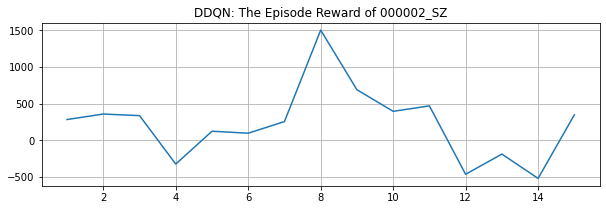

Stock: 000568_SZ


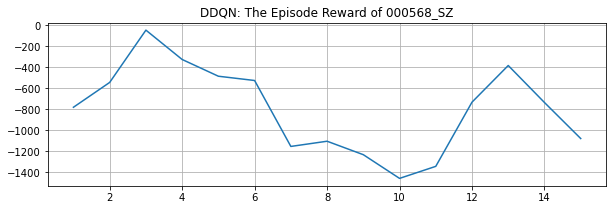

Stock: 000625_SZ


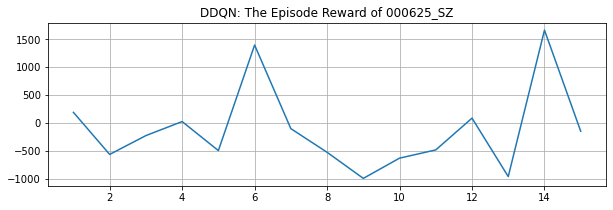

Stock: 000776_SZ


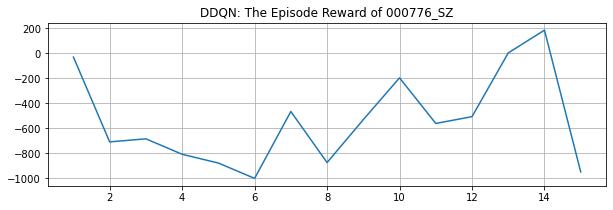

Stock: 002311_SZ


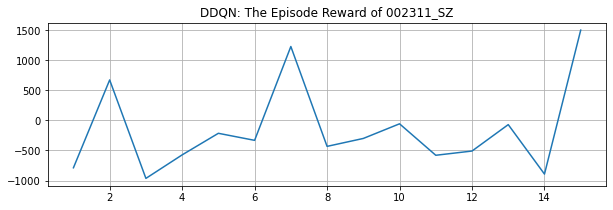

Stock: 002415_SZ


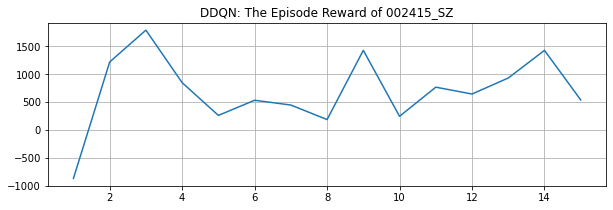

Stock: 002594_SZ


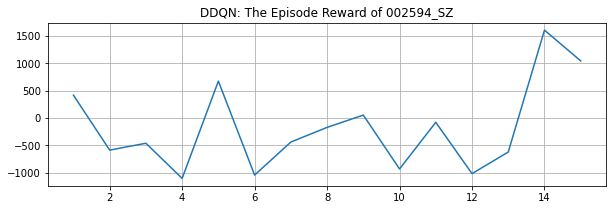

Stock: 600009_SH


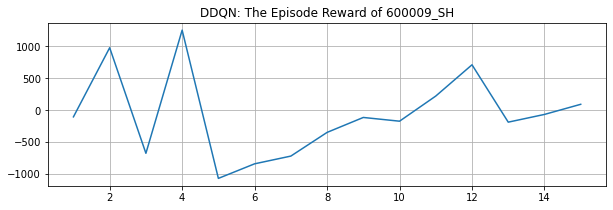

Stock: 600028_SH


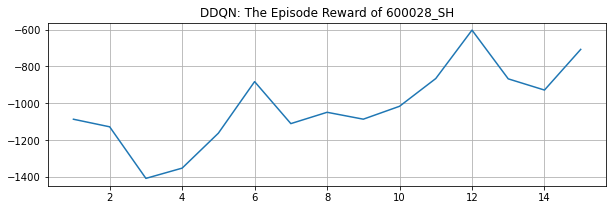

Stock: 600031_SH


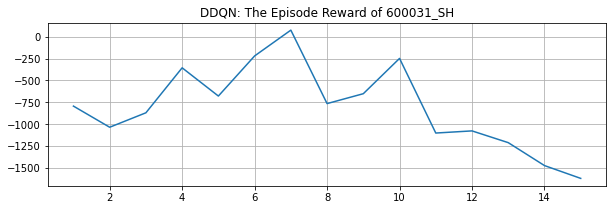

In [3]:
for name in stockName[:10]:
    print('Stock:', name)
    IL_DDQN_train(episode=15, minimum=1500, stockName=name, lambda_1=0.5, lambda_2=0.5)

In [3]:
# DQN Imitative Learning
import torch
from Data.stock_data import data
from Model.ILQN.IL_Agent import IL_Agent_2
from Env.trainEnv import portfolio_trainEnv
# 专家训练
from Expert.Imitate_Expert import Expert
#  智能体
agent = IL_Agent_2(state_dim=150, hidden_dim=30, action_dim=3, lr=0.001, device="cuda:0", gamma=0.95,  epsilon=0.01, target_update=10)

def IL_DQN_train(episode, minimum, stockName, lambda_1, lambda_2):
    link = r'..\Data\\'+stockName+'.csv'
    train_df = data(link, window_length=15, t=2000).train_data()
    # 训练环境
    Env = portfolio_trainEnv(day=0, balance=100000, stock=train_df, cost=0.003)
    # 专家
    expert = Expert(path=link, timeperiod=15)
    expert_transition_dict = expert.sample_expert_data(K=2000)
    return_List = []
    for i in range(episode):
        # print('Episode:', i)
        done = False
        episode_return  = 0
        state = Env.reset()  # 返回初始状态
        state = torch.tensor(state.values, dtype=torch.float32).view(1, -1).to(device="cuda:0")
        # 经验池
        transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': [],
            }
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, _ = Env.step(action)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action+1)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            next_state = torch.tensor(next_state.values, dtype=torch.float32).view(1, -1).to(device="cuda:0")
            transition_dict['next_states'].append(next_state)
            state = next_state
            episode_return += reward
            if len(transition_dict['states'])>= minimum:
               # 算法优化 超参数灵敏度分析
               agent.update(transition_dict, expert_transition_dict, lambda_1, lambda_2)
        return_List.append(episode_return)

    # 模型保存
    PATH = r'..\Model\ILQN\result\DQN\agent_dqn_'+stockName+'_'+str(lambda_1).replace('.', '_')+'.pt'
    torch.save(agent.state_dict(), PATH, _use_new_zipfile_serialization=False)
    import matplotlib.pyplot as plt
    # 每慕内奖励总和
    time = []
    for i in train_df:
        time.append(str(i.index.unique().values[-1]))
    Name = link.split('\\')[-1].split('.')[0]
    # 策略收益率
    plt.figure(figsize=(10, 3))
    plt.title('DQN: The Episode Reward of '+Name)
    plt.grid()
    plt.plot(range(1, len(return_List)+1), return_List)
    plt.show()
    # return return_List

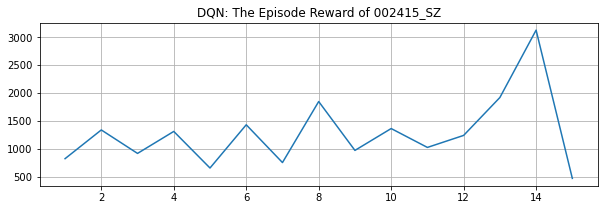

In [5]:
# 单只股票ILDQN训练
IL_DQN_train(episode=15, minimum=1500, stockName=stockName[4], lambda_1=0.5, lambda_2=0.5)

In [3]:
stockName

['000001_SZ', '000002_SZ', '000651_SZ', '000938_SZ', '002415_SZ']

Stock: 000001_SZ


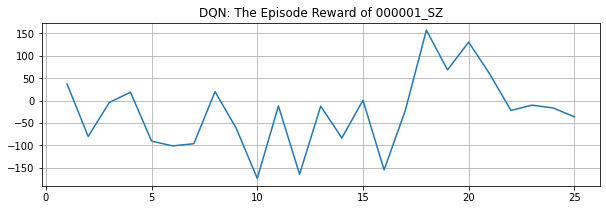

Stock: 000002_SZ


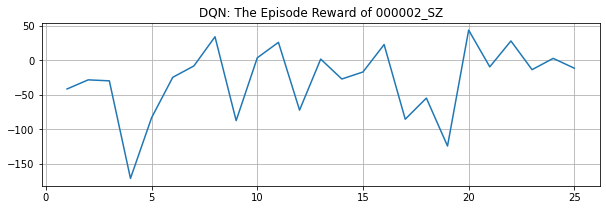

Stock: 000651_SZ


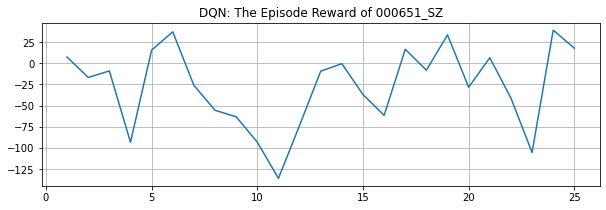

Stock: 000938_SZ


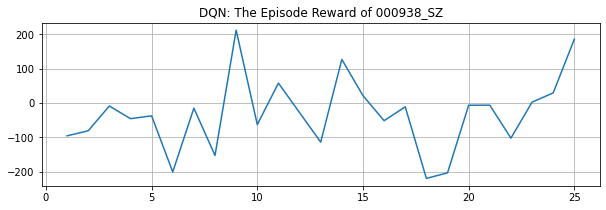

Stock: 002415_SZ


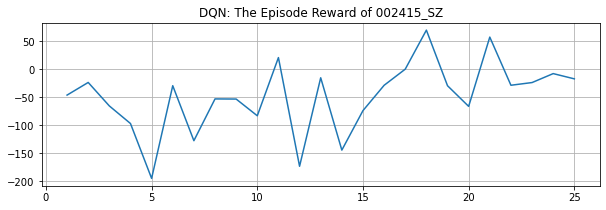

In [6]:
for name in stockName:
    print('Stock:', name)
    IL_DQN_train(episode=25, minimum=1500, stockName=name, lambda_1=0.5, lambda_2=0.5)